In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(8,10)})
#plt.rcParams['figure.figsize']= (5,5)

In [2]:
#!pip install plotly
#!pip install cufflinks
from plotly import __version__
print(__version__)
import cufflinks as cv
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)
cv.go_offline()
#pd.DataFrame(new_value).iplot(kind='surface',)

5.3.1


In [3]:
import sys
sys.setrecursionlimit(4000)   #2000
print(sys.getrecursionlimit())

4000


In [4]:
size = 500
width= 10

# Demo

# MAIN Function

In [5]:
# Noise
from sklearn.datasets import make_blobs
def CreateNoiseImage(input_image):
    global size
    global noise_matrix
    data = make_blobs(n_samples= 2800, n_features= 13, centers= 4, cluster_std =3, random_state=1)
    #plt.figure(figsize=(8,8))
    #plt.scatter(data[0][:,0],data[0][:,1], c = data[1], cmap='rainbow')

    if size==1000:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*860).astype(int)
    elif size== 500:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*460).astype(int)
    data1[:,1] += 10
    
    noise_matrix = -1*np.ones((size,size,3))
    for i,j in data1[:,:2]:
        noise_matrix[j,i,:] = -5
    
    import matplotlib.pyplot as plt
    """
    im = plt.imread('../Images/img4.jpg')[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    """
    fig = plt.figure()
    im = input_image
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    
    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()
    out_image = plt.imread("../Images/img4_noise.jpg")
    #plt.show()
    return out_image
t=CreateNoiseImage(plt.imread('../Images/img4.jpg')[:size,:size,:])

<Figure size 432x288 with 0 Axes>

In [6]:
def Calculate_noise(img):
    global width
    global size
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            t = img[i:i+width,j:j+width,:]
            no_5 = (t==-5).sum()
            #pixel_value = np.max(img[i:i+width,j:j+width,:])
            #if pixel_value==-5:
               # print(pixel_value)
            if no_5 <= 3:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-7,-1) # 230
    return img_transition_value

In [7]:
img = cv2.imread("../Images/img4.jpg")[:size,:size,:]    #[:1000,:1000,:]
def Calculate_transition_matrix(img):
    global noise_matrix
    global width
    global size
    global noise
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            pixel_value = np.mean(img[i:i+width,j:j+width,:])
            if pixel_value >210:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-80,-1) # 230 
    
    ## noise
    #i1 = cv2.imread("noise1.PNG")
    #i1=cv2.resize(i1,(size,size))
    #img_transition_value = np.minimum(i2,img_transition_value)
    if noise == True:
      i2=Calculate_noise(noise_matrix)
      img_transition_value = np.minimum(img_transition_value,i2 )
    ##
    #print("final reward")
    #sns.heatmap(img_transition_value)
    #plt.show()
    return img_transition_value

In [8]:
def Sweep(Value, Policy,terminators,transition_value):
    # create transition matrix globally that is not possible since we will create dynamic wall
    New_Value = Value.copy()
    delta = 0
    x,y = Value.shape
    for i in range(x):  # x
        left = 0
        right = 0
        top = 0
        bottom = 0
        for j in range(y):  # y
            # (i,j)  
            if (i,j) in terminators:
                pass
            else:
                same= Value[i,j]
                if i==0:
                    left = same
                else:
                    left = Value[i-1,j]
                if i==x-1:
                    right= same
                else:
                    right = Value[i+1,j]
                if j==0:
                    top= same
                else:
                    top = Value[i,j-1]
                if j==y-1:
                    bottom= same
                else:
                    bottom = Value[i ,j+1]
#                 if (i,j) in red:
#                     transition_reward = -10
#                 else:
#                     transition_reward = -1
                transition_reward = transition_value[i,j]
                total_value = Policy[(y)*i+j,0]*(transition_reward+left) + Policy[(y)*i+j,1]*(transition_reward+right) + Policy[(y)*i+j,2]*(transition_reward+top) + Policy[(y)*i+j,3]*(transition_reward+bottom)
                #print(total_value, New_Value[i,j])
                delta = max(delta, np.abs(total_value- Value[i,j]))
                New_Value[i,j] = total_value    
    #print("Sweep")
    return New_Value, delta

In [9]:
def Improve_Policy(Value, Policy):
    New_Policy = Policy.copy()
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    x,y = Value.shape
    for i in range(x):
        for j in range(y):  # y
            # (i,j)  
            left = 0
            right = 0
            top = 0
            bottom = 0
            same= Value[i,j]
            if i==0:
                left = same
            else:
                left = Value[i-1,j]
            if i==x-1:
                right= same
            else:
                right = Value[i+1,j]
            if j==0:
                top= same
            else:
                top = Value[i,j-1]
            if j==y-1:
                bottom= same
            else:
                bottom = Value[i ,j+1]
            my_list = [left,right, top,bottom]
            max_val = max(my_list)
            my_list = np.array(my_list)
            my_list = (my_list==max_val).astype(int)
            my_list = my_list/np.sum(my_list)
            New_Policy[(y)*i+j,:] = my_list
    #print("Improve_Policy")
    return New_Policy

In [10]:
call =0
def Evaluate_value(Value, Policy,theta,terminators,transition_value):
    Policy = Policy.copy()
    theta = theta
    terminators = terminators.copy()
    Policy = Policy.copy()
    global call
    call += 1
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    delta = float(np.inf)
    while delta> theta:
        delta = 0
        Value, delta = Sweep(Value, Policy, terminators,transition_value)
        #print(delta,theta, delta>theta)
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    New_Policy = Improve_Policy(Value, Policy)
    if np.all(Policy==New_Policy):
        #print("Evaluate_value_")
        return Value, New_Policy, theta, terminators
    else:
        # repeat
        #print("Evaluate_value")
        return Evaluate_value(Value, New_Policy,theta, terminators,transition_value)

In [11]:
def Calculate_optimal(Grid_shape,no_actions, terminators,img_mask):
    global img
    global find_optimal_CS
    global Charging_time_CS
    global static_quality_score
    global dynamic_quality_score
    global transition_value
    global actual_dynamic_overhead
    global actual_static_overhead # we can't add charging time before we calculate rem overhead
    x,y = Grid_shape
    State_action = np.ones((x*y,no_actions))*(1/no_actions)  #######  L     R     T     B
    Value = np.zeros((x,y))
    theta = 0.1 #0.001
    
    transition_value = Calculate_transition_matrix(img_mask)
#     for i,j in HOME:
#         transition_value[i,j] = 0  
    for no, (i,j) in enumerate(HOME):
        transition_value[i,j] = 0
        if static_quality_score == True or dynamic_quality_score == True:
          if i != 0:
            # not touching left edge
            transition_value[i,j-1] = min(transition_value[i,j-1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if i != 49:
            # not touching right edge
            transition_value[i,j+1] = min(transition_value[i,j+1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 0:
            # not touching top edge
            transition_value[i-1,j] = min(transition_value[i-1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 49:
            # not touching bottom edge
            transition_value[i+1,j] = min(transition_value[i+1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          
#     print("REWARD of each state:-")
#     sns.heatmap(transition_value)
#     plt.show()
#     Value[17,24] = 30
#     terminators.append((17,24))
#     print("terminators",terminators)
    
    #transition_value[25,25] = 1
    #img[25*width-10-70:25*width+10-70,25*width-10:25*width+10,:] = 0
    #Value[HOME] = 0 # No matter how low you make it (-4000) this will become optimal point because everywhere else value is calculated

    l,m,th,tr =Evaluate_value(Value,State_action,79, terminators, transition_value) #l:- value function m:- optimal action
    
    if find_optimal_CS == False and dynamic_quality_score== False:
      print('-'*40)
      print("calculating FUTURE REWARD of each state...")
      print("-"*40)
      print(l)
      print('FUTURE REWARD/Value Functions:-')
#     g2=sns.heatmap(l)
#     g2.tick_params(left=False)  # remove the ticks  #tick_params(left=False)  # remove the ticks
#     plt.tight_layout()
#     plt.show()
    

    if dynamic_quality_score == False:
      f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(18,6))
      g1 = sns.heatmap(transition_value,ax=ax1)
      g1.set_ylabel('')
      g1.set_xlabel('')
      g2 = sns.heatmap(l,ax=ax2)
      g2.set_ylabel('')
      g2.set_xlabel('')
      plt.show()
    
    
#     layout1 = cv.Layout(
#     height=500,
#     width=500
#     )
    if static_quality_score == True and dynamic_quality_score == False:
      # 3d plot
      new_value = (l-np.min(l))/(np.max(l)-np.min(l))
      pd.DataFrame(new_value).iplot(kind='surface',) # layout= layout1)
    
    #print("Calculate_optimal")         # 80 for -100 , 9.5 for -10 , 100 for -1000  60 for -80
    return l,m              

In [12]:
def recheck(x,y):
  global HOME
  global optimal_value
  global AGENT
  global dynamic_quality_score
  global actual_dynamic_overhead
  global actual_static_overhead
  global terminators
  global state
  global battery
  global Overhead_time_CS
  global Charging_time_CS
  global no_steps
  global stats_df
  
  index_no = HOME.index((x,y))
  time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
  rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
  stats_df.loc[index_no,"CS_pos"] = str((x,y))
  stats_df.loc[index_no,"travel_time"] = time_taken
  stats_df.loc[index_no, "rem_overhead"] = rem_overhead
  stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
  if rem_overhead <= 0:
    # means none can be better than this cs.
    # stop
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    print(stats_df)
    if battery == True:
      #print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]} minutes")
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {time_taken + rem_overhead + Charging_time_CS[index_no]} minutes")
    else:
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charging_time_CS[index_no]}")
    print('-'*40)
    return
  else:
    # change transition matrix
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    #print("Calculating...")
    print(stats_df)
    actual_dynamic_overhead[index_no] = rem_overhead
    actual_static_overhead[index_no]  = Charging_time_CS[index_no]
    state = 112
    """
    Grid_shape = transition_matrix.shape
    no_actions = 4
    
    optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    """

In [13]:
optimal_path = np.zeros((50,50))
collect_pts = []
def trace_path(optimal_value, optimal_policy,initial_pt):
    global optimal_path
    global width 
    global collect_pts
    global dynamic_quality_score
    global Last_CS 
    x,y = initial_pt  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y) or (x,y)== HOME[-1]):
          # we will check once again
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          print("REACHED HOME")
          return
    if x<0 or x>= 50 or y<0 or y>= 50:
        # stop execution
        return
    # Plot
    a1 = width*y
    b1 = width*x
    a2 = width*y + width
    b2 = width*x + width
    
    #
    policy_index = x*50 + y
    l,r,t,b = optimal_policy[policy_index,:]
    max_index = (l,r,t,b).index(max(l,r,t,b)) # pick the first optimal index
    indexes = [i for i,j in enumerate((l,r,t,b)) if j==max(l,r,t,b)]
    max_index = random.choice(indexes)
    if max_index==0:
        # left
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x-1,y))
        optimal_path[x-1:x,y:y+1] += 1
    elif max_index==1:
        # right
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    elif max_index==2:
        # top
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y-1))
        optimal_path[x:x+1,y-1:y] += 1
    elif max_index==3:
        # bottom 
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    else:
        print("ERROR")

In [14]:
def draw_path():
    global optimal_path
    global img
    global width
    global size
    print('calculating')
    Full_matrix = (np.repeat(np.repeat(optimal_path,width,axis=0),width,axis=1)*500).astype(int)
    img = ((np.clip((img - Full_matrix.reshape(size,size,1)).astype(int),0,255)).astype(int)).astype(np.uint8)

In [15]:
A = np.array([[0,3],[5,0]])
A

array([[0, 3],
       [5, 0]])

In [16]:
np.repeat(np.repeat(A,3,axis=0),3,axis=1)

array([[0, 0, 0, 3, 3, 3],
       [0, 0, 0, 3, 3, 3],
       [0, 0, 0, 3, 3, 3],
       [5, 5, 5, 0, 0, 0],
       [5, 5, 5, 0, 0, 0],
       [5, 5, 5, 0, 0, 0]])

In [17]:
def smart_trace():
    #print('tracing path..')
    print("="*80)
    global optimal_value
    global optimal_policy
    global width 
    global size
    global battery
    
    global dynamic_quality_score
    global actual_dynamic_overhead
    global Last_CS
    global no_checked_CS
    global no_steps
    global stats_df
    global Overhead_time_CS
    global HOME
    global Charging_time_CS
    
    if width == 20:
      w = 10
    elif width == 10:
      w = 10
    T =np.argmax(optimal_policy, axis=1)
    x_dict = {0:-1,1:1,2:0,3:0}
    y_dict = {0:0,1:0,2:-1,3:1}
    x_axis=np.vectorize(x_dict.get)(T)
    y_axis=np.vectorize(y_dict.get)(T)
    #f_x ,f_y = HOME
    in_x, in_y = AGENT
    no_steps = 0
    if width == 20:
      r = 2
    elif width == 10:
      r = 3
    while (in_x,in_y) not in HOME: #in_x != f_x or in_y != f_y:
        no_steps += 1
        m = w*in_x
        l = w*in_y
        cv2.circle(img, ((2*l+w)//2,(2*m+w)//2),r,(0,255,0),5)
        new_loc = 50*in_x + in_y
        in_x += x_axis[new_loc]
        in_y += y_axis[new_loc]
        #print("action",x_axis[new_loc],y_axis[new_loc])
        #print("reached",in_x,in_y)
        if l<0 or l>999 or m <0 or m>999:
            print('Not found',(2*l + w),(2*m + w))
            return

 
    x,y = in_x, in_y  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y)) and no_checked_CS != len(actual_dynamic_overhead):
          # we will check once again
          no_checked_CS += 1
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          rem_overhead = 0
          Charge_t = 0
          if dynamic_quality_score == True:
            index_no = HOME.index((x,y))
            time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
            rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
            stats_df.loc[index_no,"CS_pos"] = str((x,y))
            stats_df.loc[index_no,"travel_time"] = time_taken
            stats_df.loc[index_no, "rem_overhead"] = rem_overhead
            stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
            Charge_t = Charging_time_CS[index_no]
            print(stats_df)
          if battery == True:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]+rem_overhead+Charge_t} minutes")
          else:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charge_t}")
          print('-'*40)
          return


In [18]:
import time

In [19]:
def Calculate_Cost(index):
    global drag
    global state
    global HOME
    global AGENT
    global optimal_value
    global img
    global Grid_shape
    global no_action
    global terminators
    global optimal_path
    global width
    global size
    global optimal_policy
    global time_limit
    
    img_mask = cv2.imread("../Images/img4.jpg")[:size,:size,:]
    terminators = [(index[0],index[1])]
    HOME = terminators
    v,p= Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    return v,p

In [20]:
def Optimize_CS():
    global non_path_reward  #-80
    global tile_size
    List_indices = []
    List_costs = []
    
    img_mask = cv2.imread("../Images/img4.jpg")[:size,:size,:]
    transition_value = Calculate_transition_matrix(img_mask)
    """
    HOME = [(3,3)]
    for i,j in HOME:
        transition_value[i,j] = 0
    """
    mask = transition_value> non_path_reward+2
    #print(np.where(mask==1))
    # pick tile_size which can divide 50 like 10/50/2 etc
    no_subcell = 50//tile_size
    for i in range(0,no_subcell):
        for j in range(0,no_subcell):
            # (i,j)
            # pick su
            x,y = np.where(mask[i*tile_size: i*tile_size+tile_size, j*tile_size: j*tile_size+tile_size])
            x =  (i*tile_size) + x
            y =  (j*tile_size) + y
            my_list = list(zip(x,y))
            if my_list == []:
                print("no road here")
            else:
                print(my_list)
                length = len(my_list)
                if length %2 != 0:
                    # odd no of terms
                    middle = my_list[(length-1)//2]
                else:
                    # even no of terms
                    middle = my_list[(length//2) -1]
                temp_transition_value = (transition_value[i*tile_size: i*tile_size+tile_size, j*tile_size: j*tile_size+tile_size]).copy()
                print(f"Calculating cost for {middle}")
                temp_transition_value[middle[0]-(i*tile_size),middle[1]-(j*tile_size)] = 10
                plt.figure(figsize=(3,2))
                sns.heatmap(temp_transition_value)
                plt.show()
                
                List_indices.append(middle)
                v,p = Calculate_Cost(middle)
                cost = np.sum(v[mask])
                List_costs.append(cost)
                #print(np.random.choice(my_list, size=8))
                print(middle,"=",cost)
            print("#"*80)
    print(List_indices)
    print("+"*40)
    print(List_costs)
    print("+"*40)
    print("Optimal CS location")
    print(List_indices[List_costs.index(max(List_costs))], max(List_costs))
    Calculate_Cost(List_indices[List_costs.index(max(List_costs))])
    return [List_indices[List_costs.index(max(List_costs))]]

In [21]:
## FUNCTIONALITIES 
size =  500 #1000 #500
noise =  False #True False
battery = False
find_optimal_CS = False
static_quality_score = True
dynamic_quality_score = True
demo = True
#####################################

In [22]:


tile_size = 10
drag = False
Last_CS = (-100,-100) # something which is not in 50*50
HOME =  [] #0
AGENT = 0
Grid_shape = (50,50) #(100,100) # later set automatically
no_actions = 4
terminatos = []
optimal_path = np.zeros((50,50))
non_path_reward = -80

if static_quality_score == True:
  Charging_time_CS = [50,10, 5]
else:
  Charging_time_CS = [0, 0, 0]
if dynamic_quality_score == True:
  Overhead_time_CS = [20, 48, 47] # [40, 48, 27] #[20, 48, 47]# [40, 48, 47]  # this is for pre-booking >> can be implemented to FCFS
else:
  Overhead_time_CS = [0, 0, 0 ]
actual_dynamic_overhead = list(np.zeros((len(Overhead_time_CS),)) )
if dynamic_quality_score == False:
  actual_static_overhead = Charging_time_CS.copy()
else:
  actual_static_overhead  = list(np.zeros((len(Charging_time_CS))))
stats_df = pd.DataFrame({"Charging_time":Charging_time_CS, "Overhead_time_CS":Overhead_time_CS})
no_checked_CS = 1

if static_quality_score==True or static_quality_score == True:
  print(stats_df)

if size== 1000:
  width = 20
elif size==500:
  width = 10
w = 10

if noise == True:
  #CreateNoiseImage()
  img= CreateNoiseImage(plt.imread('../Images/img4.jpg')[:size,:size,:])
  stored_image = img.copy() #
else:
  # PATH
  #img_mask = cv2.imread("../Images/dilated_5_2.jpg")[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
  img = cv2.imread("../Images/img4.jpg")[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
img = cv2.resize(img,(500,500))

time_limit = 5000
if battery == True:
  # Limit EV Battery
  time_limit = int(input("Battery remaining:- "))
  
"""
state:click
0       No
1       set home
2       set car
3       start optimizing
4       start game
5       loop----in 5
"""


"""
if size== 1000:
  img = cv2.resize(img,(500,500))
elif size == 500:
  img = cv2.resize(img,(500,500))

# add noise
## create noise image
if noise==True:
  #img = cv2.imread("../Images/img4_noise.jpg")[:size, :size] #[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
  img = cv2.resize(img,(500,500))
"""  
#
#img = cv2.cvtColor(img, cv2.Color_BGR2RGB)
cv2.namedWindow("window")
optimal_value = 0
state =0 
can_initial_reward = -1

if demo == True:
  HOME = [(25,28),(19,34),(19,16)]
  count = 0
  AGENT  = (43,30)
def draw(event, x, y, flag, param):
    global drag
    global state
    global HOME
    global AGENT
    global optimal_value
    global img
    global Grid_shape
    global no_action
    global terminators
    global optimal_path
    global width
    global size
    global optimal_policy
    global find_optimal_CS
    global Last_CS
    global count
    
    if width == 20:
      # big rectangle
      w = 10
    elif width == 10:
      w = 10
    if event == cv2.EVENT_FLAG_LBUTTON:
        drag = True
    if event == cv2.EVENT_LBUTTONUP:
        drag=False
        #cv2.circle(img, (x,y),20,(0,0,0),3)
        if state == 111:
          """
            AGENT = [y//w, x//w]
            print("AGENT location")
            print(AGENT)
            cv2.rectangle(img, (x+w,y-w),(x-w, y+w), (250,0,0),3 )
            smart_trace()
            state=3
         """
          #-
          if demo== True:
            x = AGENT[1]*w
            y = AGENT[0]*w
          else:
            AGENT = [y//w, x//w]
          #-
          print("AGENT location")
          print(AGENT)
          cv2.rectangle(img, (x+w,y-w),(x-w, y+w), (250,0,0),3 )
          # Limit Battery
          t = optimal_value[AGENT[0],AGENT[1]]
          if  t< -1*time_limit and battery == True:
              print(f"Nearest Charging station is at {-1*t} second distance")
              print('*'*80)
          else:
              smart_trace()
          state=3
        if state == 0:
            if find_optimal_CS == True:
              HOME= Optimize_CS()[::-1]
              x = HOME[0][1]*w
              y = HOME[0][0]*w
              find_optimal_CS = False
            else:
              #-
              if demo == True:
                temp = HOME[count][0]*w, HOME[count][1]*w
                x = HOME[count][1]*w
                y = HOME[count][0]*w
                count += 1
              else:
                temp = (y//w,x//w)
                HOME.append(temp)
            print("CS locations")
            print(HOME)
            cv2.rectangle(img, (x+w,y-w),(x-w,y+w),(0,0,250),3)
            #state =1
        elif state == 1:
            # draw car
            if demo== True:
              x = AGENT[1]*w
              y = AGENT[0]*w
            else:
              AGENT = [y//w, x//w]
            #-
            print("AGENT location")
            print(AGENT)
            cv2.rectangle(img, (x+w,y-w),(x-w,y+w),(250,0,0),3)
            #state = 2
        elif state == 2:
            state = 3
            # show color
            terminators = HOME
            #print("terminating locations")
            #print(terminators)
            
            img_mask = cv2.imread("../Images/img4.jpg")[:size,:size,:] #[:1000,:1000,:]  # img4.jpg # this is the fresh copy not affected by any thing 
            #print()
            #print("Calculating...")
            optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
            l,m = optimal_value.shape  # (100,100)
            #img[HOME[0]*10:HOME[0]*10+10,HOME[1]*10:HOME[0]*10+10,:] = (255,0,0) it is just to verify that we are indeed at right location
            
            # Method1
            # Limit Battery
            t = optimal_value[AGENT[0],AGENT[1]]
            if  t< -1*time_limit and battery == True:
                print(f"Nearest Charging station is at {-1*t} second distance")
                print('*'*80)
            else:
                smart_trace()
            #smart_trace()
            #plt.figure(figsize=(8,3), dpi=80)
#             sns.heatmap(optimal_value)
#             g2=sns.heatmap(optimal_value)
#             g2.tick_params(left=False)  # remove the ticks  #tick_params(left=False)  # remove the ticks

#             plt.tight_layout()
#             plt.show()
            
            # Method2
            """
            trace_path(optimal_value,optimal_policy,AGENT)
            draw_path()
            
            f, axes = plt.subplots(1, 2)
            sns.heatmap(   data=optimal_value,   ax=axes[0])
            sns.heatmap(  data=optimal_path,   ax=axes[1])
            """
        elif state == 3:
            #start game
            pass
        elif state == 4:
            #print("CAlled state 4")
            # # New map img
            state=5
            if dynamic_quality_score == True:
              img_mask = cv2.imread("../Images/img4.jpg")[:size,:size,:]
              img = img_mask.copy()
            else:
              img_mask = img.copy()   # img4.jpg # this is the fresh copy not affected by any thing
            for H in HOME:
                cv2.rectangle(img, (H[1]*w+w,H[0]*w-w),(H[1]*w-w,H[0]*w+w),(0,0,250),3)
            cv2.rectangle(img, (AGENT[1]*w+w,AGENT[0]*w-w),(AGENT[1]*w-w,AGENT[0]*w+w),(250,0,0),3)
            #print()
            #print("Calculating...")
            optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
            l,m = optimal_value.shape  # (100,100)
            
            # Method1
            # Limit Battery
            t = optimal_value[AGENT[0],AGENT[1]]
            if  t< -1*time_limit and battery == True:
                print(f"Nearest Charging station is at {-1*t} second distance")
                print('*'*80)
            else:
                smart_trace()
            #smart_trace()
            #plt.figure(figsize=(8,3), dpi=80)
#             g2=sns.heatmap(optimal_value)
#             g2.tick_params(left=False)  # remove the ticks

#             plt.tight_layout()
#             plt.show()
            
            # Method2 [it was making linear search which was computationally heavy]
            """
            #trace_path(optimal_value,optimal_policy,AGENT)
            #img[HOME[0]*10:HOME[0]*10+10,HOME[1]*10:HOME[0]*10+10,:] = (255,0,0) it is just to verify that we are indeed at right location
            #draw_path()
            
            #f, axes = plt.subplots(1, 2)
            #sns.heatmap(  data=optimal_value, ax=axes[0])
            #sns.heatmap(  data=optimal_path,  ax=axes[1])
            """

            
            
    if event == cv2.EVENT_MOUSEMOVE:

        if drag ==True:
            #state=4
            cv2.circle(img, (x,y),5,(0,0,0),15)
            #cv2.circle(img, (x,y),2,(0,0,0),4)
    if state == 4 and dynamic_quality_score == True:
      # # New map img
      print("NEXT-->")
      state=5
      if dynamic_quality_score == True:
        img_mask = cv2.imread("../Images/img4.jpg")[:size,:size,:]
        img = img_mask.copy()
      else:
        img_mask = img.copy()   # img4.jpg # this is the fresh copy not affected by any thing
      for H in HOME:
          cv2.rectangle(img, (H[1]*w+w,H[0]*w-w),(H[1]*w-w,H[0]*w+w),(0,0,250),3)
      cv2.rectangle(img, (AGENT[1]*w+w,AGENT[0]*w-w),(AGENT[1]*w-w,AGENT[0]*w+w),(250,0,0),3)
      #print()
      #print("Calculating...")
      optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
      l,m = optimal_value.shape  # (100,100)

      # Method1
      # Limit Battery
      t = optimal_value[AGENT[0],AGENT[1]]
      if  t< -1*time_limit and battery == True:
          print(f"Nearest Charging station is at {-1*t} second distance")
          print('*'*80)
      else:
          smart_trace()
            

cv2.setMouseCallback("window", draw)

print(">"*40)
while True:
    cv2.imshow("window", img)
    key_val = cv2.waitKey(1)
    if key_val == ord("d"):
        # better not use this
        # time to create new image
        print(">"*40)
        optimal_path = np.zeros((50,50))
        img = cv2.imread("../Images/img4.jpg")[:size,:size,:]
        # add noise it is added by default from a function
        #img = cv2.imread("img4_noise.jpg") #[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
        img = cv2.resize(img,(500,500))
        #
    if key_val == ord("c"):
        print(">"*40)
        state = 0
        AGENT = 0
        HOME = []
        optimal_path = np.zeros((50,50))
        img = cv2.imread("../Images/img4.jpg")[:size,:size,:]
        # add noise
        img = cv2.imread("../Images/img4_noise.jpg") #[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
        img = cv2.resize(img,(size,size))
        #
    if key_val == ord("a") and state==0:
        state = 1 # click to set agent
    if key_val == ord("a") and state==3:
        if noise == True:
          #img = cv2.imread("../Images/img4_noise.jpg")[:size,:size] #[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
          img = stored_image
        else:
          img = cv2.imread("../Images/img4.jpg")[:size, :size]
        img = cv2.resize(img,(500,500))
        # add CS locations
        for H in HOME:
                cv2.rectangle(img, (H[1]*w+w,H[0]*w-w),(H[1]*w-w,H[0]*w+w),(0,0,250),3)
        #cv2.rectangle(img, (AGENT[1]*width+width,AGENT[0]*width-width),(AGENT[1]*width-width,AGENT[0]*width+width),(250,0,0),3)
        state = 111
        
    if key_val == ord("p") and state == 1:
        # play started
        
        state = 2 # click to play
    if key_val == ord("p") and (state == 3 or state == 5):
        state = 4
    if key_val == 27:
        break
    if state== 112:
      state = 4
      #draw(cv2.EVENT_LBUTTONUP, 2,3)
cv2.destroyAllWindows()
#cv2.imwrite("final_save.jpg",img)

   Charging_time  Overhead_time_CS
0             50                40
1             10                48
2              5                27
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
CS locations
[(25, 28), (19, 34), (19, 16)]
CS locations
[(25, 28), (19, 34), (19, 16)]
CS locations
[(25, 28), (19, 34), (19, 16)]
AGENT location
(43, 30)
   Charging_time  Overhead_time_CS    CS_pos  travel_time  rem_overhead  \
0             50                40  (25, 28)         20.0          20.0   
1             10                48       NaN          NaN           NaN   
2              5                27       NaN          NaN           NaN   

   total time  
0        90.0  
1         NaN  
2         NaN  
NEXT-->
   Charging_time  Overhead_time_CS    CS_pos  travel_time  rem_overhead  \
0             50                40  (25, 28)         20.0          20.0   
1             10                48  (19, 34)         28.0          20.0   
2              5                27       NaN          NaN        

In [23]:
l = optimal_value
new_value = (l-np.min(l))/(np.max(l)-np.min(l))
pd.DataFrame(new_value).iplot(kind='surface',) # layout= layout1)

<img src="../Images/download.png">

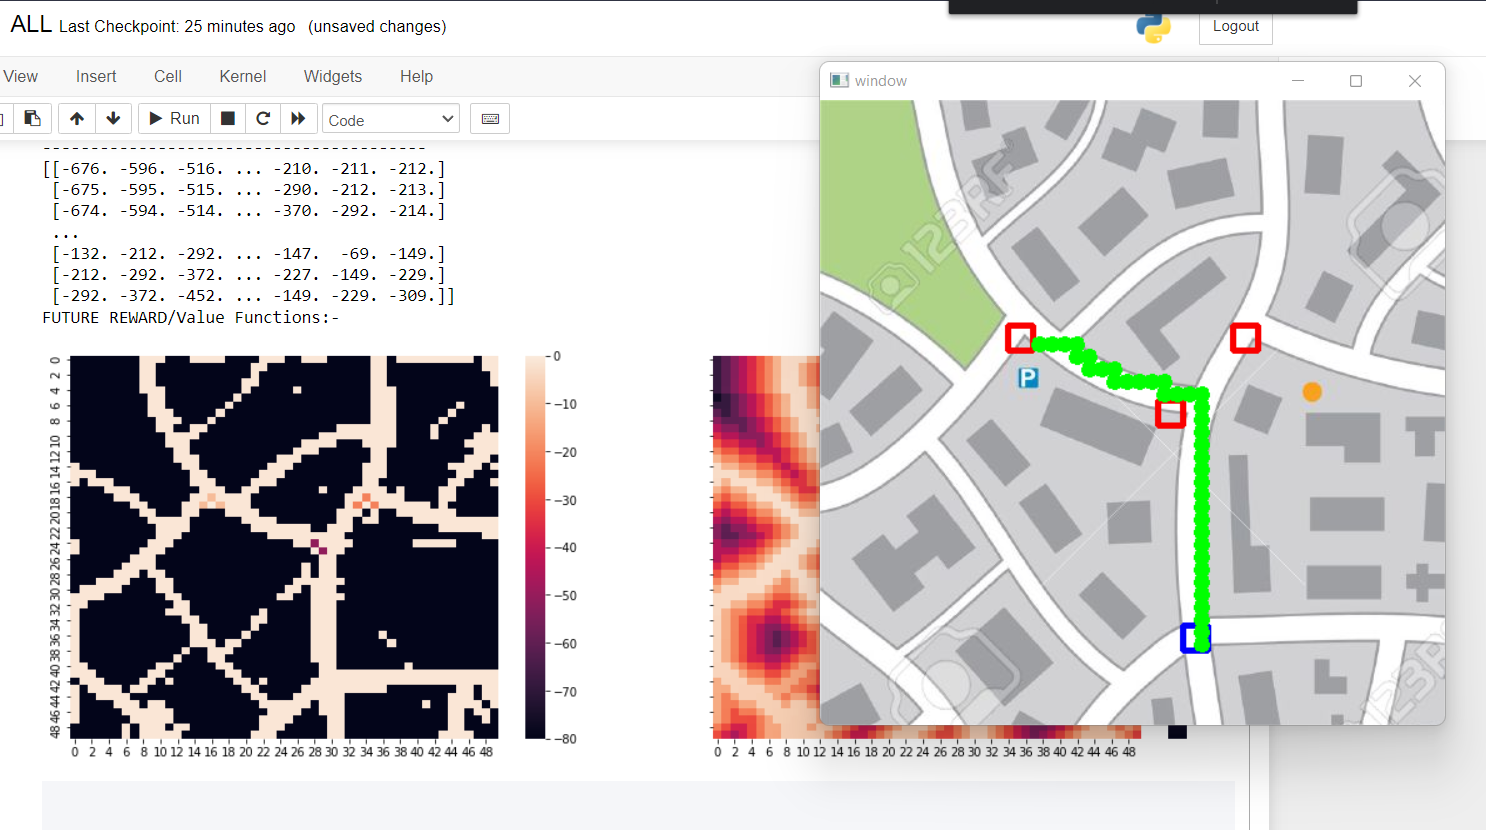

In [24]:
"""
Current overhead on CS: 40 48 47
Time taken to reach CS: 20 28 38
rem overhead on CS    : 20 20 9
  
Total time travel+charge:40 48 47

  so first will be better
  
  
NOW static quality CS: 50  10  5
total time travle+charge:90 58 52
  so third is better
"""


'\nCurrent overhead on CS: 40 48 47\nTime taken to reach CS: 20 28 38\nrem overhead on CS    : 20 20 9\n  \nTotal time travel+charge:40 48 47\n\n  so first will be better\n  \n  \nNOW static quality CS: 50  10  5\ntotal time travle+charge:90 58 52\n  so third is better\n'

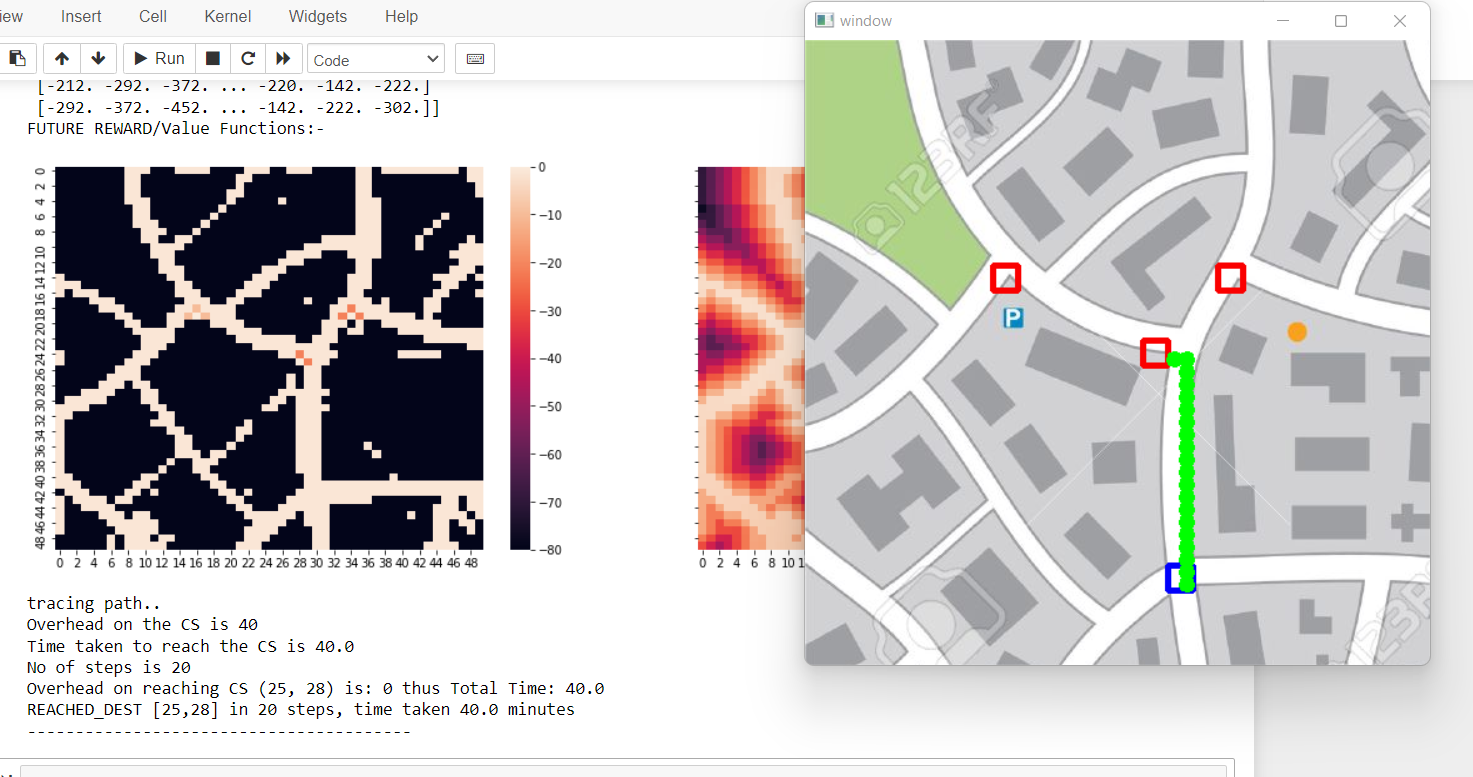

In [25]:
# Charging_time_CS = [50,10]

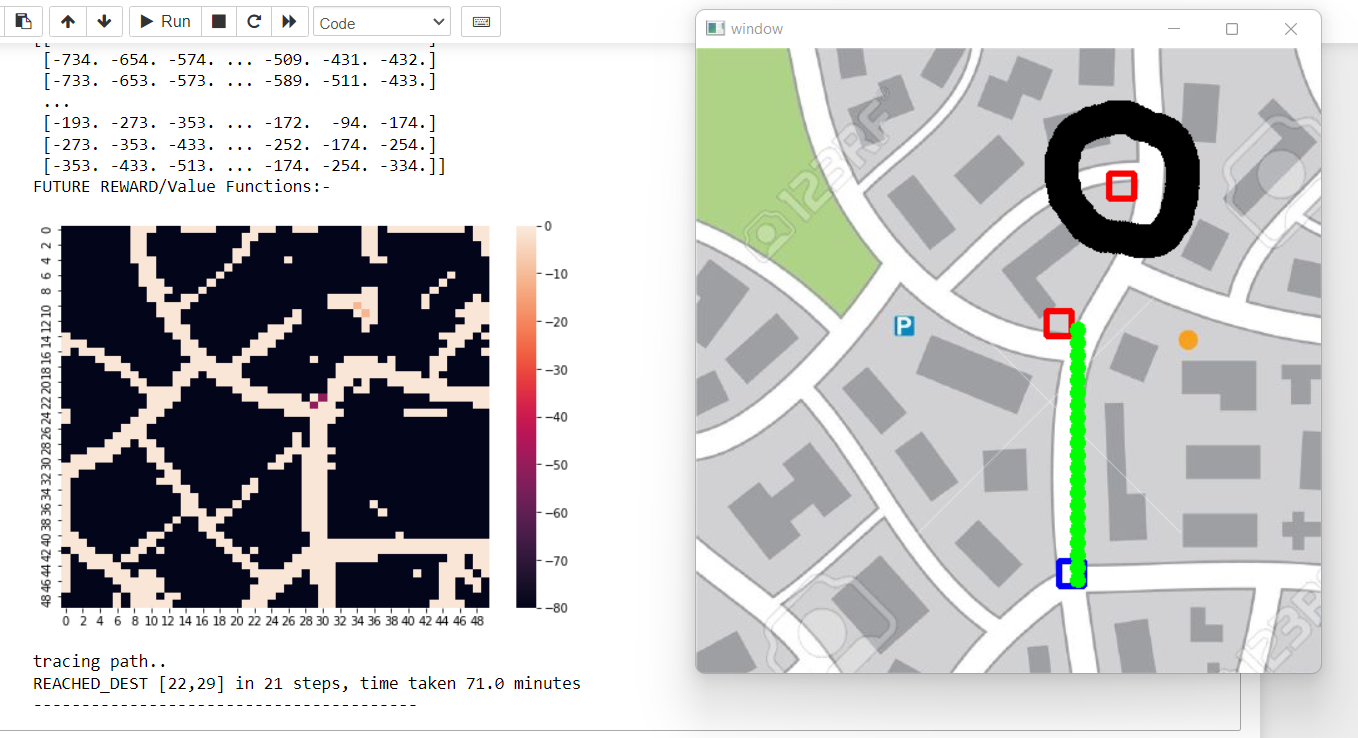

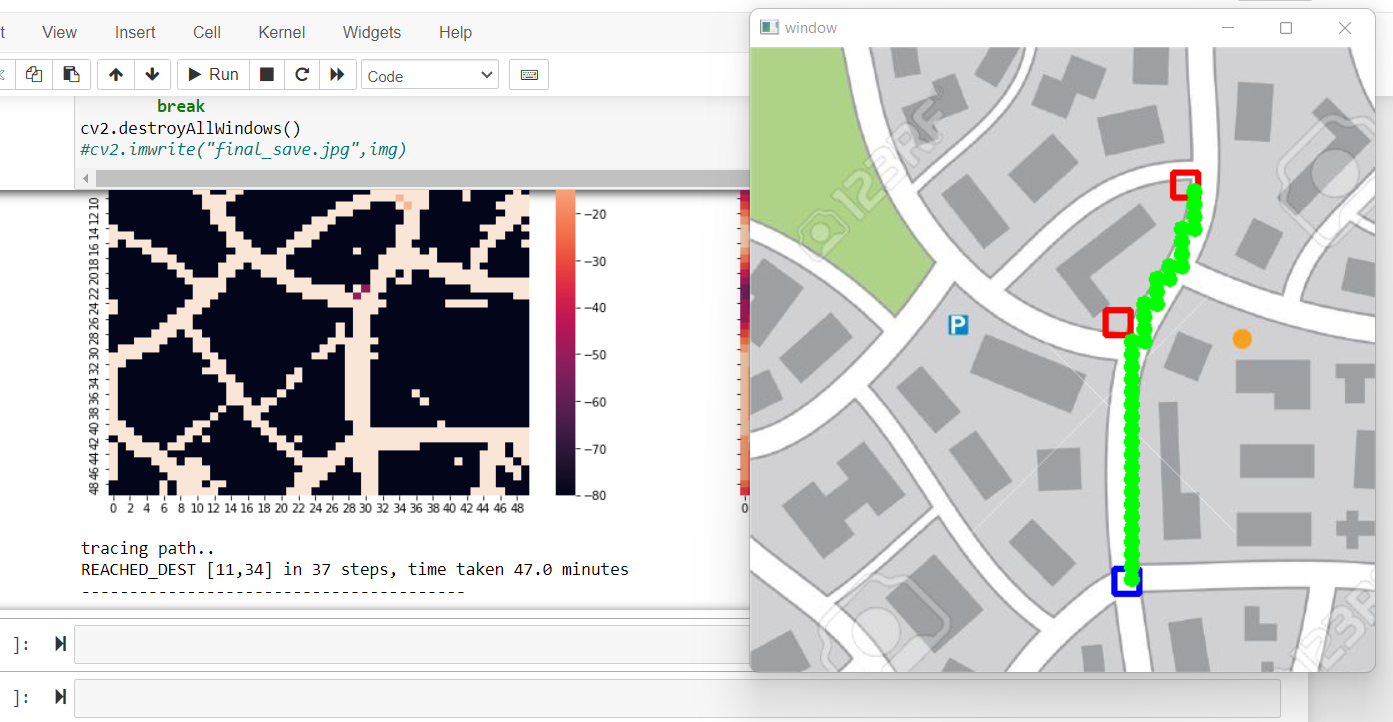

In [26]:
# -60715.0 When traffic

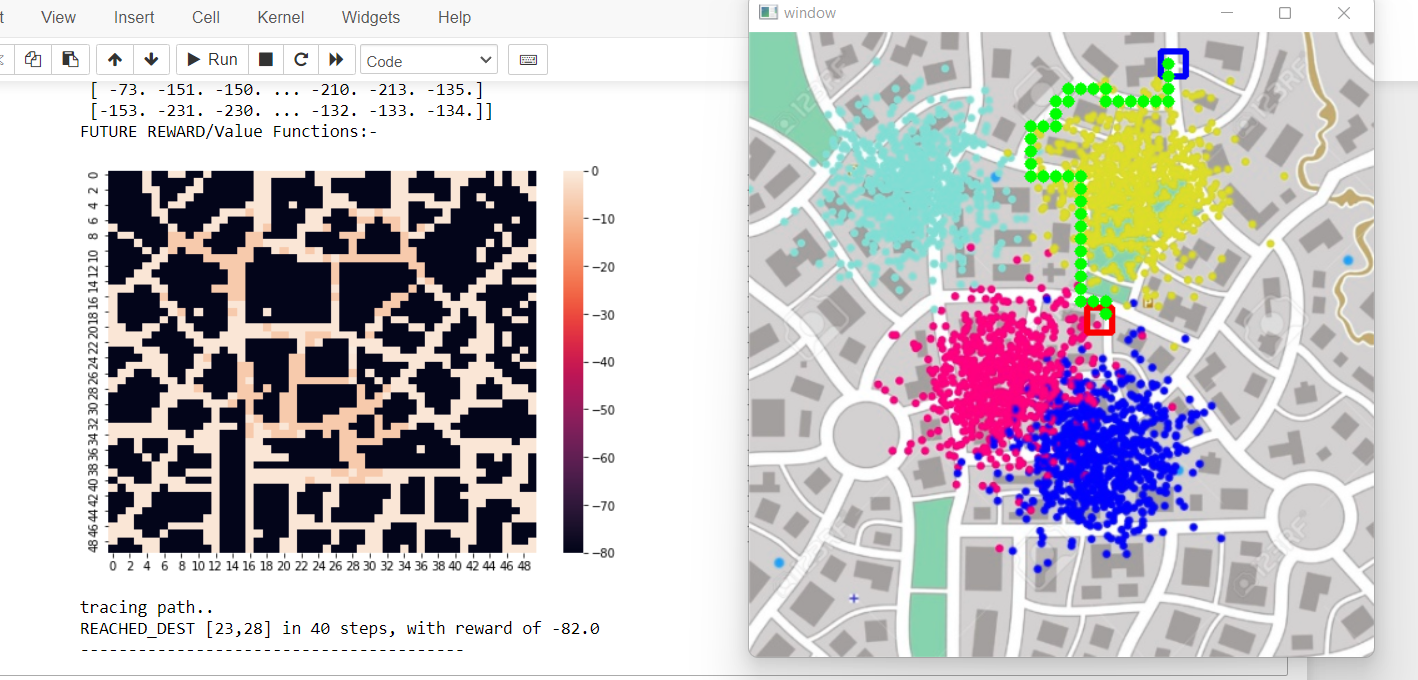

In [27]:
# -39571.0 When no traffic

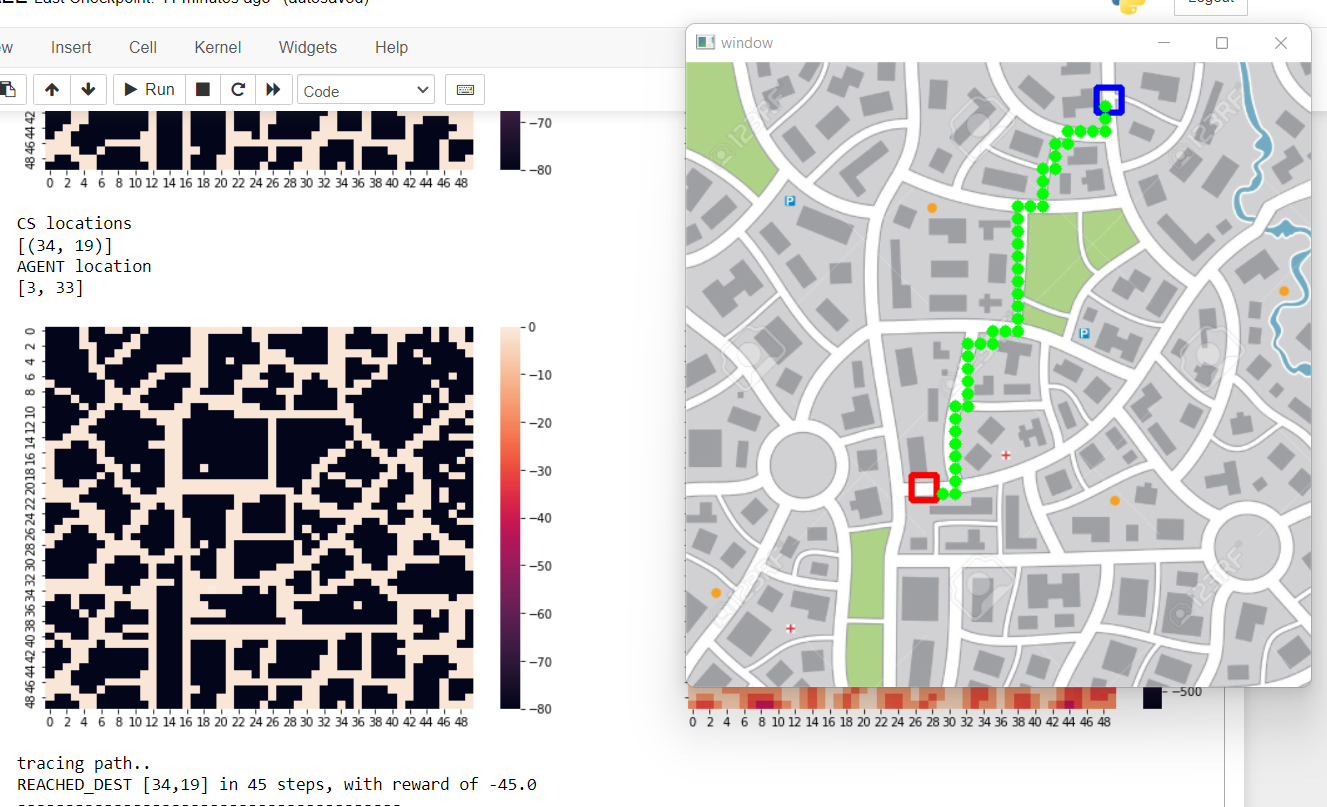

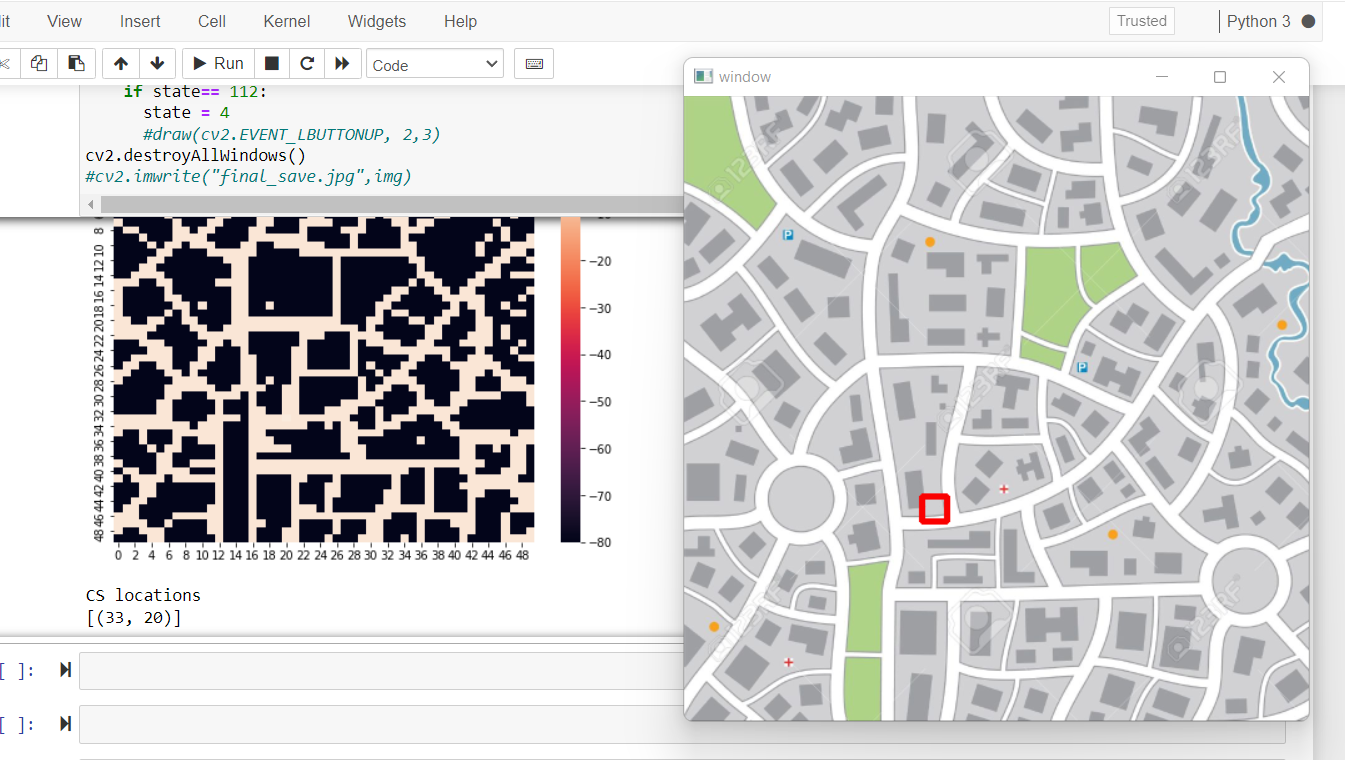

In [28]:
l = optimal_value
new_value = (l-np.min(l))/(np.max(l)-np.min(l))
pd.DataFrame(new_value).iplot(kind='surface',) # layout= layout1)

In [29]:
for H in HOME:
    print(optimal_value[H])  # terminating position has fixed q value and not the fixed transition value

0.0
0.0
0.0


In [30]:
AGENT

(43, 30)

In [31]:
optimal_value[AGENT[0],AGENT[1]]

-38.0

In [32]:
HOME

[(25, 28), (19, 34), (19, 16)]

<AxesSubplot:>

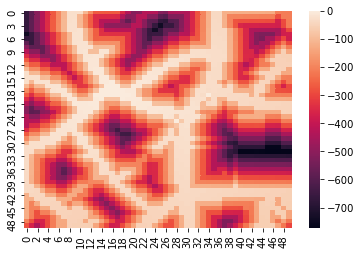

In [33]:
sns.heatmap(optimal_value)

In [34]:
new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
pd.DataFrame(new_value).iplot(kind='surface',)

In [35]:
pd.DataFrame(new_value).iplot(kind='surface',)

In [36]:
# In figure we see (17,24) creates a spike which makes it hard to leave once an agent enters it.
# Hence setting some reward of 30 and HOME 55 didn't help!

# BUT setting multiple HOME solved the problem